# Errors

In [14]:
%load_ext autoreload
%autoreload 2
from load import load_3D
from liftpose.vision_3d import XY_coord_dict, Z_coord_dict
import yaml
import logging
from imp import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
import seaborn as sns
import pandas as pd
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir'       : r"\Users\NeLy\Desktop\training_data-20210309T140605Z-001\training_data", # change the path 
             'out_dir'        : './out',
             "train_subjects" : ["004"],
             'test_subjects'  : ["002"],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from liftpose.postprocess import load_test_results
import pandas as pd
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d, prism=True)
all_err = np.sqrt(np.abs(test_3d_gt - test_3d_pred).mean(axis=-1)) * 2.5 / 400
ttl_err = pd.DataFrame(all_err.reshape(-1,5))
ttl_err.columns.names = ['frame']
ttl_err = ttl_err.rename(columns={1:'coxa-femur',2:'femur-tibia',3:'tibia-tarsus',4:'tarsus-tip'})

(0.0, 0.03)

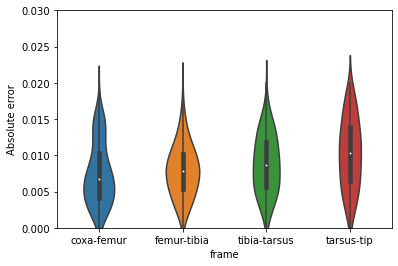

In [16]:
ttl_err1 = ttl_err.unstack().reset_index()
ttl_err1 = ttl_err1.rename(columns={0:'Absolute error'})
q = ttl_err1.quantile(q=0.99)
ttl_err1 = ttl_err1.loc[ttl_err1['Absolute error'] < q['Absolute error']]
sns.violinplot(x="frame", y='Absolute error', data=ttl_err1,bw=0.4, width=0.4, order=['coxa-femur', 'femur-tibia', 'tibia-tarsus', 'tarsus-tip'])
plt.ylim([0,0.03])